In [1]:
import os
import shutil

# Define the base directory path
base_dir = '/kaggle/input/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset'

# Define the source directories for test and train data
test_dir = os.path.join(base_dir, 'test')
train_dir = os.path.join(base_dir, 'train')

# Define the target directory where combined data will be stored
combined_dir = '/kaggle/working/combined'  # You can change this path as needed
os.makedirs(combined_dir, exist_ok=True)

# Create subdirectories for benign and malignant in the combined directory
combined_benign_dir = os.path.join(combined_dir, 'benign')
combined_malignant_dir = os.path.join(combined_dir, 'malignant')
os.makedirs(combined_benign_dir, exist_ok=True)
os.makedirs(combined_malignant_dir, exist_ok=True)

# Function to copy files from source to target directory
def copy_files(source_dir, target_dir):
    for filename in os.listdir(source_dir):
        source_path = os.path.join(source_dir, filename)
        target_path = os.path.join(target_dir, filename)
        shutil.copy2(source_path, target_path)

# Copy benign images from test and train to combined_benign_dir
copy_files(os.path.join(test_dir, 'benign'), combined_benign_dir)
copy_files(os.path.join(train_dir, 'benign'), combined_benign_dir)

# Copy malignant images from test and train to combined_malignant_dir
copy_files(os.path.join(test_dir, 'malignant'), combined_malignant_dir)
copy_files(os.path.join(train_dir, 'malignant'), combined_malignant_dir)

print("Data combined successfully!")

Data combined successfully!


In [2]:
# Install required packages
!pip install -q timm
!pip install -q grad-cam==1.4.6 pylibraft-cu12==24.12.0 rmm-cu12==24.12.0 pylibcugraph-cu12==24.12.0

# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    confusion_matrix, f1_score, matthews_corrcoef, roc_auc_score, 
    precision_recall_curve, roc_curve, auc, precision_score, recall_score
)

import torch
import torch.nn as nn
from torch.utils.data import Subset, DataLoader
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.optim import AdamW

from tqdm.notebook import tqdm
import timm
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

# Set seed and device
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("✅ Environment ready — All packages installed successfully.")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcugraph-cu12 24.12.0 requires pylibraft-cu12==24.12.*, but you have pylibraft-cu12 25.2.0 which is incompatible.
pylibcugraph-cu12 24.12.0 requires rmm-cu12==24.12.*, but you have rmm-cu12 25.2.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
DATA_DIR = "/kaggle/working/combined"
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225])
])

dataset = ImageFolder(DATA_DIR, transform=transform)
class_names = dataset.classes
labels = [sample[1] for sample in dataset.samples]
print(f"✅ Dataset size: {len(dataset)}")
print(f"✅ Class counts: {Counter(labels)}")
print(f"✅ Class names: {class_names}")


✅ Dataset size: 10605
✅ Class counts: Counter({0: 5500, 1: 5105})
✅ Class names: ['benign', 'malignant']


In [4]:
!pip install dicenet

ERROR: Could not find a version that satisfies the requirement dicenet (from versions: none)
ERROR: No matching distribution found for dicenet


In [5]:
import torch
import torch.nn as nn
import timm

class DiCENetWrapper(nn.Module):
    def __init__(self, num_classes: int = 2):
        super().__init__()
        # use the DLA-46x-C backbone from timm…
        self.model = timm.create_model('dla46x_c', pretrained=True, num_classes=num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

# instantiate
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DiCENetWrapper(num_classes=2).to(device)
print(model)


model.safetensors:   0%|          | 0.00/4.35M [00:00<?, ?B/s]

DiCENetWrapper(
  (model): DLA(
    (base_layer): Sequential(
      (0): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (level0): Sequential(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (level1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (level2): DlaTree(
      (downsample): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (project): Sequential(
        (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): Batc

In [6]:
def train_validate(model, train_loader, val_loader, epochs=10):
    optimizer = AdamW(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    best_val_loss = float('inf')
    patience = 5
    wait = 0
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
        val_losses.append(val_loss / len(val_loader))

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}")

        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            wait = 0
            torch.save(model.state_dict(), "best_dicenet.pt")
        else:
            wait += 1
            if wait >= patience:
                print(" Early stopping triggered.")
                break

    return train_losses, val_losses


In [7]:
from math import ceil
from collections import Counter
from sklearn.model_selection import train_test_split, StratifiedKFold

# 0️⃣ Prep
N = len(dataset)
labels_int = [int(lbl) for _, lbl in dataset.samples]
n_classes  = len(set(labels_int))

# 1️⃣ Compute hold-out sizes (ensuring ≥1/sample per class)
test_n  = max(n_classes, ceil(0.15 * N))
val_n   = max(n_classes, ceil(0.05  * N))
train_n = N - test_n - val_n
assert train_n >= n_classes, "Not enough samples for training after hold-outs"

print(f"🔢 Total: {N}")
print(f"   ▶️ Train (80%):      {train_n}")
print(f"   ▶️ Val   (5%):       {val_n}")
print(f"   ▶️ Test  (15%):      {test_n}\n")

# 2️⃣ First carve out TEST
all_idx = list(range(N))
train_val_idx, test_idx = train_test_split(
    all_idx,
    test_size=test_n,
    stratify=labels_int,
    random_state=SEED
)
print(f"▶ After test split:   {len(train_val_idx)} train+val, {len(test_idx)} test")

# 3️⃣ Then carve out VAL from train+val
train_idx, val_idx = train_test_split(
    train_val_idx,
    test_size=val_n,
    stratify=[labels_int[i] for i in train_val_idx],
    random_state=SEED
)
print(f"▶ After val split:    {len(train_idx)} train, {len(val_idx)} val\n")

# 4️⃣ Now 10-fold CV on the 80% TRAINING set
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)
tv_labels = [labels_int[i] for i in train_idx]

for fold, (t_sub, v_sub) in enumerate(skf.split(train_idx, tv_labels), start=1):
    tr_fold_idx = [train_idx[i] for i in t_sub]
    vl_fold_idx = [train_idx[i] for i in v_sub]
    print(f"Fold {fold:2d}: Train samples = {len(tr_fold_idx):5d},  “Inner” Val samples = {len(vl_fold_idx):4d}")


🔢 Total: 10605
   ▶️ Train (80%):      8483
   ▶️ Val   (5%):       531
   ▶️ Test  (15%):      1591

▶ After test split:   9014 train+val, 1591 test
▶ After val split:    8483 train, 531 val

Fold  1: Train samples =  7634,  “Inner” Val samples =  849
Fold  2: Train samples =  7634,  “Inner” Val samples =  849
Fold  3: Train samples =  7634,  “Inner” Val samples =  849
Fold  4: Train samples =  7635,  “Inner” Val samples =  848
Fold  5: Train samples =  7635,  “Inner” Val samples =  848
Fold  6: Train samples =  7635,  “Inner” Val samples =  848
Fold  7: Train samples =  7635,  “Inner” Val samples =  848
Fold  8: Train samples =  7635,  “Inner” Val samples =  848
Fold  9: Train samples =  7635,  “Inner” Val samples =  848
Fold 10: Train samples =  7635,  “Inner” Val samples =  848


In [8]:
# ─── Cell (updated): 80/5/15 Split + 10-fold Stratified CV with per-fold saving ───
from math import ceil
from collections import Counter
from sklearn.model_selection import train_test_split, StratifiedKFold
from torch.utils.data import DataLoader, Subset
import torch

# 1️⃣ Prepare indices & labels
N          = len(dataset)
labels_int = [int(lbl) for _, lbl in dataset.samples]
n_classes  = len(set(labels_int))
all_idx    = list(range(N))

# 2️⃣ Compute absolute hold-out counts (≥1 per class)
test_n  = max(n_classes, ceil(0.15 * N))
val_n   = max(n_classes, ceil(0.05  * N))
train_n = N - test_n - val_n
assert train_n >= n_classes, f"Not enough train samples: {train_n} < {n_classes}"

print(f"🔢 Total: {N} → Train: {train_n}, Val: {val_n}, Test: {test_n}")

# 3️⃣ Hold out TEST set
train_val_idx, test_idx = train_test_split(
    all_idx, test_size=test_n, stratify=labels_int, random_state=SEED
)
print(f"▶ Train+Val: {len(train_val_idx)}, Test: {len(test_idx)}")

# 4️⃣ Hold out VALIDATION set from train+val
train_idx, val_idx = train_test_split(
    train_val_idx, test_size=val_n,
    stratify=[labels_int[i] for i in train_val_idx],
    random_state=SEED
)
print(f"▶ Train: {len(train_idx)}, Val: {len(val_idx)}, Test: {len(test_idx)}\n")

# 5️⃣ 10-fold CV on TRAIN set
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)
fold_metrics      = []
train_losses_list = []
val_losses_list   = []

for fold, (train_sub, val_sub) in enumerate(
    skf.split(train_idx, [labels_int[i] for i in train_idx]), start=1
):
    # map back to full-dataset indices
    tr_idx = [train_idx[i] for i in train_sub]
    vl_idx = [train_idx[i] for i in val_sub]
    print(f"📂 Fold {fold}/10 — inner Train: {len(tr_idx)}, inner Val: {len(vl_idx)}")

    # DataLoaders
    train_loader = DataLoader(Subset(dataset, tr_idx), batch_size=10, shuffle=True,
                              num_workers=4, pin_memory=True)
    val_loader   = DataLoader(Subset(dataset, vl_idx), batch_size=10, shuffle=False,
                              num_workers=4, pin_memory=True)

    # train & early stop (saves best_dicenet.pt)
    model = DiCENetWrapper(num_classes=2).to(device)
    t_losses, v_losses = train_validate(model, train_loader, val_loader)
    train_losses_list.append(t_losses)
    val_losses_list.append(v_losses)

    # reload & save this fold’s best weights
    ckpt = f"best_dicenet_fold{fold}.pt"
    model.load_state_dict(torch.load("best_dicenet.pt", map_location=device))
    torch.save(model.state_dict(), ckpt)
    print(f"💾 Saved fold {fold} weights → {ckpt}")

    # evaluate on inner validation
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for imgs, lbls in val_loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            outs  = model(imgs)
            probs = torch.softmax(outs, dim=1)
            preds = torch.argmax(probs, dim=1)
            y_true.extend(lbls.cpu().tolist())
            y_pred.extend(preds.cpu().tolist())
            y_prob.extend(probs[:, 1].cpu().tolist())

    fold_metrics.append((y_true, y_pred, y_prob))

# 6️⃣ (Optional) Evaluate on static VAL & TEST sets here...


🔢 Total: 10605 → Train: 8483, Val: 531, Test: 1591
▶ Train+Val: 9014, Test: 1591
▶ Train: 8483, Val: 531, Test: 1591

📂 Fold 1/10 — inner Train: 7634, inner Val: 849
Epoch 1/10 - Train Loss: 1.2743 | Val Loss: 0.2201
Epoch 2/10 - Train Loss: 0.2658 | Val Loss: 0.6885
Epoch 3/10 - Train Loss: 0.2516 | Val Loss: 0.2601
Epoch 4/10 - Train Loss: 0.2304 | Val Loss: 5.6507
Epoch 5/10 - Train Loss: 0.2491 | Val Loss: 0.1415
Epoch 6/10 - Train Loss: 0.2369 | Val Loss: 0.2288
Epoch 7/10 - Train Loss: 0.2089 | Val Loss: 0.1434
Epoch 8/10 - Train Loss: 0.2214 | Val Loss: 0.1693
Epoch 9/10 - Train Loss: 0.2112 | Val Loss: 0.2012
Epoch 10/10 - Train Loss: 0.2158 | Val Loss: 0.2280
 Early stopping triggered.
💾 Saved fold 1 weights → best_dicenet_fold1.pt


/tmp/ipykernel_19/472277857.py:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_dicenet.pt", map_location=device))


📂 Fold 2/10 — inner Train: 7634, inner Val: 849
Epoch 1/10 - Train Loss: 1.0024 | Val Loss: 0.3854
Epoch 2/10 - Train Loss: 0.2544 | Val Loss: 0.2057
Epoch 3/10 - Train Loss: 0.2370 | Val Loss: 0.2612
Epoch 4/10 - Train Loss: 0.2237 | Val Loss: 0.1849
Epoch 5/10 - Train Loss: 0.2151 | Val Loss: 0.2658
Epoch 6/10 - Train Loss: 0.2419 | Val Loss: 0.2132
Epoch 7/10 - Train Loss: 0.2325 | Val Loss: 0.2262
Epoch 8/10 - Train Loss: 0.2136 | Val Loss: 0.1731
Epoch 9/10 - Train Loss: 0.2145 | Val Loss: 0.1922
Epoch 10/10 - Train Loss: 0.2183 | Val Loss: 0.3156
💾 Saved fold 2 weights → best_dicenet_fold2.pt
📂 Fold 3/10 — inner Train: 7634, inner Val: 849
Epoch 1/10 - Train Loss: 1.4343 | Val Loss: 0.2610
Epoch 2/10 - Train Loss: 0.2642 | Val Loss: 0.2414
Epoch 3/10 - Train Loss: 0.2235 | Val Loss: 0.2031
Epoch 4/10 - Train Loss: 0.2198 | Val Loss: 0.2677
Epoch 5/10 - Train Loss: 0.2003 | Val Loss: 0.1876
Epoch 6/10 - Train Loss: 0.2076 | Val Loss: 0.1946
Epoch 7/10 - Train Loss: 0.2053 | Val Lo

/tmp/ipykernel_19/2189188524.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"best_dicenet_fold{best_fold}.pt", map_location=device))


Validation Report:
               precision    recall  f1-score   support

           0       0.93      0.94      0.93       275
           1       0.93      0.92      0.93       256

    accuracy                           0.93       531
   macro avg       0.93      0.93      0.93       531
weighted avg       0.93      0.93      0.93       531

Test Report:
               precision    recall  f1-score   support

           0       0.93      0.94      0.93       825
           1       0.93      0.92      0.93       766

    accuracy                           0.93      1591
   macro avg       0.93      0.93      0.93      1591
weighted avg       0.93      0.93      0.93      1591



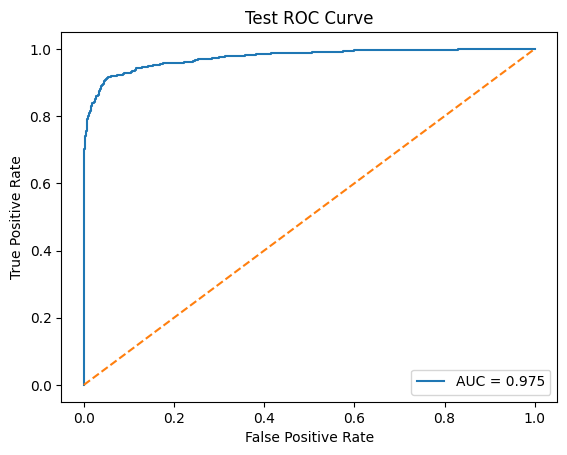

In [9]:
# ─── Cell: Evaluate on static VAL & TEST sets ───
import torch
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt

# 1️⃣ Static DataLoaders
val_loader = DataLoader(
    Subset(dataset, val_idx),
    batch_size=10, shuffle=False,
    num_workers=4, pin_memory=True
)
test_loader = DataLoader(
    Subset(dataset, test_idx),
    batch_size=10, shuffle=False,
    num_workers=4, pin_memory=True
)

# 2️⃣ Helper to get preds & probs
def evaluate(model, loader):
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            logits = model(imgs)
            probs  = torch.softmax(logits, dim=1)[:, 1]
            preds  = (probs >= 0.5).long()
            y_true.extend(lbls.cpu().tolist())
            y_pred.extend(preds.cpu().tolist())
            y_prob.extend(probs.cpu().tolist())
    return y_true, y_pred, y_prob

# 3️⃣ Reload best fold (replace best_fold logic as needed)
best_fold = 3  # ← set this to the fold with highest val AUC
model = DiCENetWrapper(num_classes=2).to(device)
model.load_state_dict(torch.load(f"best_dicenet_fold{best_fold}.pt", map_location=device))

# 4️⃣ Evaluate
yv_t, yv_p, yv_pr = evaluate(model, val_loader)
yt_t, yt_p, yt_pr = evaluate(model, test_loader)

# 5️⃣ Classification reports
print("Validation Report:\n", classification_report(yv_t, yv_p))
print("Test Report:\n",      classification_report(yt_t, yt_p))

# 6️⃣ ROC curve & save
fpr, tpr, _ = roc_curve(yt_t, yt_pr)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Test ROC Curve")
plt.legend()
plt.savefig("roc_test.png")
plt.show()


 Best Fold:         1
 F1 Score:          0.9431
 MCC:               0.8916
 Specificity:       0.9591
 PR AUC:            0.9882
 ROC AUC:           0.9864
 Confusion matrix saved to: /kaggle/working/plots/confusion_matrix_best_fold_1.png


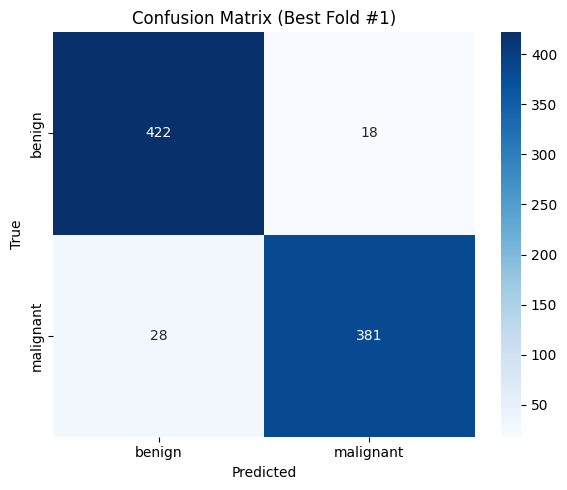

In [10]:
# ─── Cell (updated): Metrics & save confusion matrix for best fold ───
import os
import numpy as np
from sklearn.metrics import (
    confusion_matrix, precision_recall_curve, auc,
    f1_score, matthews_corrcoef, roc_auc_score
)
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure output directory exists
output_dir = "/kaggle/working/plots"
os.makedirs(output_dir, exist_ok=True)

# Determine best fold by highest ROC AUC
roc_aucs = [
    roc_auc_score(y_true_i, y_prob_i)
    for y_true_i, _, y_prob_i in fold_metrics
]
best_idx = int(np.argmax(roc_aucs))         # zero-based index
best_fold = best_idx + 1                    # human-readable fold number
y_true, y_pred, y_prob = fold_metrics[best_idx]

# Compute metrics for best fold
f1   = f1_score(y_true, y_pred)
mcc  = matthews_corrcoef(y_true, y_pred)
cm   = confusion_matrix(y_true, y_pred)
specificity = cm[0, 0] / cm[0].sum()
precision, recall, _ = precision_recall_curve(y_true, y_prob)
pr_auc = auc(recall, precision)
best_auc = roc_aucs[best_idx]

# Print metrics
print(f" Best Fold:         {best_fold}")
print(f" F1 Score:          {f1:.4f}")
print(f" MCC:               {mcc:.4f}")
print(f" Specificity:       {specificity:.4f}")
print(f" PR AUC:            {pr_auc:.4f}")
print(f" ROC AUC:           {best_auc:.4f}")

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix (Best Fold #{best_fold})")
plt.tight_layout()

# Save figure
fig_path = os.path.join(output_dir, f"confusion_matrix_best_fold_{best_fold}.png")
plt.savefig(fig_path)
print(f" Confusion matrix saved to: {fig_path}")

plt.show()


➡️ Learning curve saved to: /kaggle/working/plots/learning_curve_best_fold_1.png


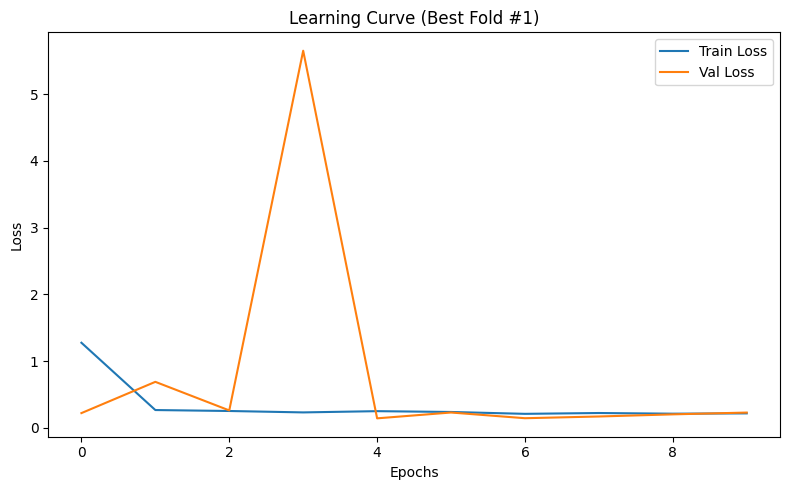

➡️ ROC curve saved to: /kaggle/working/plots/roc_curve_best_fold_1.png


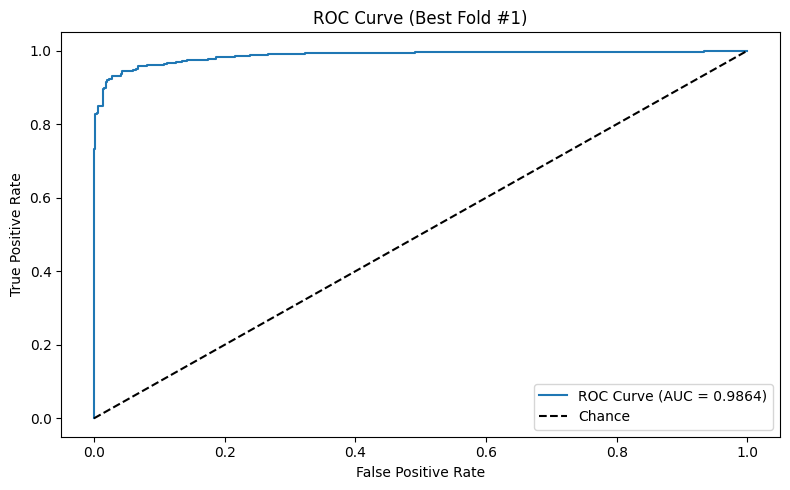

In [11]:
# ─── Cell (updated): Learning & ROC curves for best fold, saved to plots ───
import os
import numpy as np
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# Ensure output directory exists
output_dir = "/kaggle/working/plots"
os.makedirs(output_dir, exist_ok=True)

# Determine best fold by highest ROC AUC
roc_aucs = [
    roc_auc_score(y_true_i, y_prob_i)
    for y_true_i, _, y_prob_i in fold_metrics
]
best_idx = int(np.argmax(roc_aucs))         # zero-based index
best_fold = best_idx + 1                    # human-readable fold number

# Retrieve best fold results
y_true, y_pred, y_prob = fold_metrics[best_idx]

# Retrieve loss histories for best fold (ensure these lists are populated)
train_losses_best = train_losses_list[best_idx]
val_losses_best   = val_losses_list[best_idx]

# Learning Curve
plt.figure(figsize=(8, 5))
plt.plot(train_losses_best, label="Train Loss")
plt.plot(val_losses_best,   label="Val Loss")
plt.title(f"Learning Curve (Best Fold #{best_fold})")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
lc_path = os.path.join(output_dir, f"learning_curve_best_fold_{best_fold}.png")
plt.savefig(lc_path)
print(f"➡️ Learning curve saved to: {lc_path}")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Chance")
plt.title(f"ROC Curve (Best Fold #{best_fold})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
roc_path = os.path.join(output_dir, f"roc_curve_best_fold_{best_fold}.png")
plt.savefig(roc_path)
print(f"➡️ ROC curve saved to: {roc_path}")
plt.show()


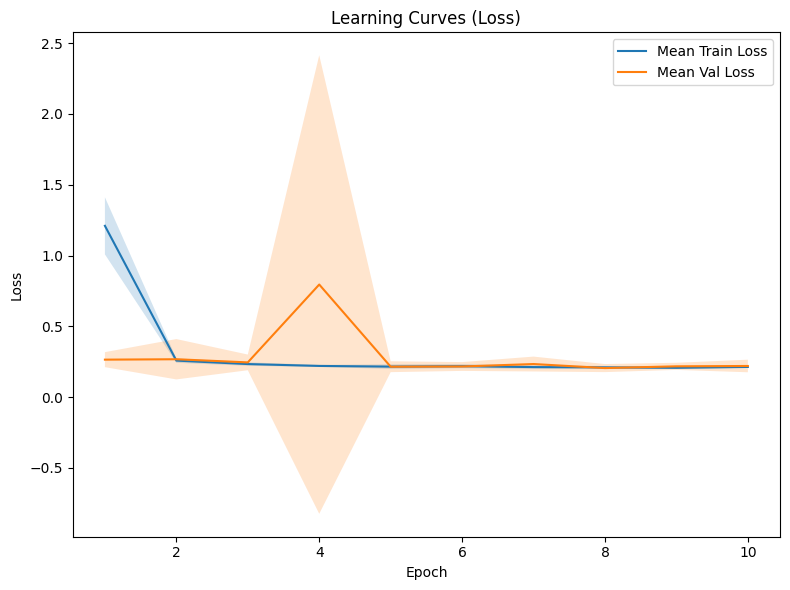

In [12]:
# ─── Cell: Plot avg ±σ Learning Curves across folds ───
import numpy as np
import matplotlib.pyplot as plt

# Assume train_losses_list and val_losses_list are lists of per-epoch loss lists, one per fold

# 1️⃣ Find max number of epochs
max_epochs = max(len(losses) for losses in train_losses_list)

# 2️⃣ Pad shorter folds with NaN so we can average
train_arr = np.array([
    np.pad(losses, (0, max_epochs - len(losses)), constant_values=np.nan)
    for losses in train_losses_list
])
val_arr = np.array([
    np.pad(losses, (0, max_epochs - len(losses)), constant_values=np.nan)
    for losses in val_losses_list
])

# 3️⃣ Compute mean and std, ignoring the padding
mean_train = np.nanmean(train_arr, axis=0)
std_train  = np.nanstd(train_arr, axis=0)
mean_val   = np.nanmean(val_arr, axis=0)
std_val    = np.nanstd(val_arr, axis=0)

# 4️⃣ Plot
epochs = np.arange(1, max_epochs + 1)
plt.figure(figsize=(8, 6))
plt.plot(epochs, mean_train, label='Mean Train Loss')
plt.fill_between(epochs, mean_train - std_train, mean_train + std_train, alpha=0.2)
plt.plot(epochs, mean_val,   label='Mean Val Loss')
plt.fill_between(epochs, mean_val   - std_val,   mean_val   + std_val,   alpha=0.2)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curves (Loss)')
plt.legend()
plt.tight_layout()
plt.savefig("Learning carve.png")
plt.show()


/tmp/ipykernel_19/4223794671.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"best_dicenet_fold{best_fold}.pt", map_location=device))


✅ Saved 8 side-by-side pairs to '/kaggle/working/grad-cam-final'


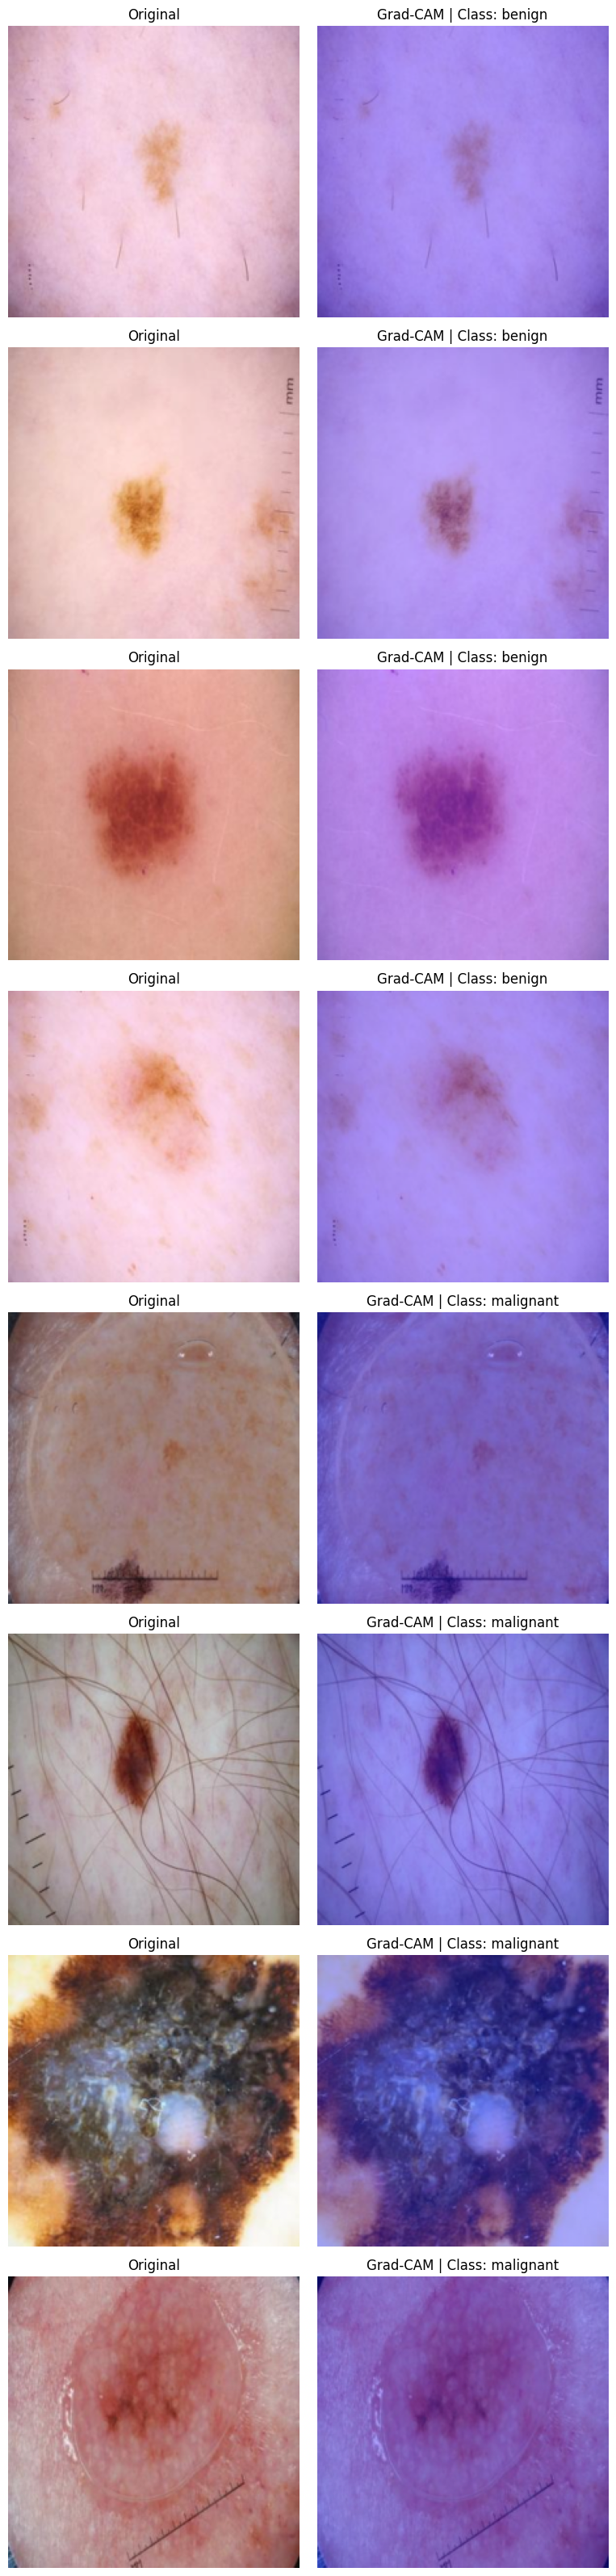

In [13]:
# ─── Cell: Save & Display Side-by-Side Original & Grad-CAM (4 images per class) ───
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch.nn as nn
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# 1️⃣ Load model & weights (make sure DiCENetWrapper, device, best_fold are defined)
model = DiCENetWrapper(num_classes=2).to(device)
model.load_state_dict(torch.load(f"best_dicenet_fold{best_fold}.pt", map_location=device))
model.eval()

# 2️⃣ Auto-select the deepest Conv2d layer
all_mods     = list(model.model.modules())
target_layer = next(m for m in reversed(all_mods) if isinstance(m, nn.Conv2d))

cam = GradCAM(model=model, target_layers=[target_layer], use_cuda=(device.type=="cuda"))

# 3️⃣ Normalization (same as training)
mean = np.array([0.485, 0.456, 0.406])
std  = np.array([0.229, 0.224, 0.225])

# 4️⃣ Prepare output directory
save_dir = "/kaggle/working/grad-cam-final"
os.makedirs(save_dir, exist_ok=True)

# 5️⃣ Collect 4 originals & overlays per class
counts      = {0: 0, 1: 0}
originals   = {0: [], 1: []}
overlays    = {0: [], 1: []}
class_names = {0: "benign", 1: "malignant"}

for imgs, lbls in val_loader:
    imgs, lbls = imgs.to(device), lbls.to(device)
    for i in range(imgs.size(0)):
        cls = int(lbls[i].item())
        if counts[cls] >= 4:
            continue

        # Original
        img_np = imgs[i].permute(1,2,0).cpu().numpy()
        img_np = np.clip((img_np * std) + mean, 0, 1)
        originals[cls].append(img_np)

        # Grad-CAM
        inp = imgs[i].unsqueeze(0)
        cam_map = cam(input_tensor=inp, targets=[ClassifierOutputTarget(cls)])[0]
        vis     = show_cam_on_image(img_np, cam_map, use_rgb=True)
        overlays[cls].append(vis)

        counts[cls] += 1
        if all(v >= 4 for v in counts.values()):
            break
    if all(v >= 4 for v in counts.values()):
        break

# 6️⃣ Save each side-by-side pair
for cls, name in class_names.items():
    for idx in range(4):
        combined = np.concatenate((originals[cls][idx], overlays[cls][idx]), axis=1)
        img_uint8 = (combined * 255).astype(np.uint8)
        img_bgr   = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2BGR)
        fn = f"{name}_pair{idx+1}.png"
        cv2.imwrite(os.path.join(save_dir, fn), img_bgr)

print(f"✅ Saved {sum(counts.values())} side-by-side pairs to '{save_dir}'")

# 7️⃣ Display all 8 pairs (8 rows × 2 cols)
fig, axes = plt.subplots(8, 2, figsize=(8, 32))
for cls, name in class_names.items():
    start = cls * 4
    for i in range(4):
        row = start + i
        axes[row, 0].imshow(originals[cls][i])
        axes[row, 0].axis('off')
        axes[row, 0].set_title("Original")
        axes[row, 1].imshow(overlays[cls][i])
        axes[row, 1].axis('off')
        axes[row, 1].set_title(f"Grad-CAM | Class: {name}")
plt.tight_layout()
plt.show()
